In [184]:
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import seaborn as sns
import torch
import torch.nn as nn
from torch.utils.data import Dataset, DataLoader
from torch import optim

import pytorch_lightning as pl
from pytorch_lightning.callbacks import Callback
from pytorch_lightning.callbacks.early_stopping import EarlyStopping
from pytorch_lightning.callbacks import TQDMProgressBar
from pytorch_lightning import loggers as pl_loggers

plt.rcParams['figure.figsize'] = (2, 2)

In [110]:
class MyDataset(Dataset):
    def __init__(self, train_features, train_targets_scored):
        gexp_cols = train_features.columns[train_features.columns.str.contains("g-")]
        viability_cols = train_features.columns[train_features.columns.str.contains("c-")]  
        X_gexp = train_features[gexp_cols].values
        X_viability = train_features[viability_cols].values

        self.X_gexp = torch.tensor(X_gexp, dtype=torch.float32)
        self.X_viability = torch.tensor(X_viability, dtype=torch.float32)
        self.y = torch.tensor(train_targets_scored.values, dtype=torch.float32)

    def __len__(self):
        return len(self.X_gexp)

    def __getitem__(self,idx):
        return self.X_gexp[idx], self.X_viability[idx], self.y[idx]

In [111]:
train_features = pd.read_csv('data/train_features.csv', index_col=0)
train_drug = pd.read_csv('data/train_drug.csv', index_col=0)
train_targets_scored = pd.read_csv('data/train_targets_scored.csv', index_col=0)
train_targets_nonscored = pd.read_csv('data/train_targets_nonscored.csv', index_col=0)
test_features = pd.read_csv('data/test_features.csv', index_col=0)

In [112]:
my_data = MyDataset(train_features, train_targets_scored)
train_loader=DataLoader(my_data, batch_size=128, shuffle=False)

In [113]:
# use 20% of training data for validation
train_set_size = int(len(my_data) * 0.8)
valid_set_size = len(my_data) - train_set_size

# split the train set into two
seed = torch.Generator().manual_seed(42)
train_set, valid_set = torch.utils.data.random_split(my_data, [train_set_size, valid_set_size], generator=seed)

train_loader = DataLoader(train_set, batch_size=128, shuffle=True)
valid_loader = DataLoader(valid_set, batch_size=128, shuffle=False)

In [169]:
class PredTask(pl.LightningModule):
    def __init__(self, model):
        super().__init__()
        self.model = model
        self.loss_func = nn.BCELoss()

    def forward(self, batch):
        output = self.model(batch)
        return output
    
    def _shared_step(self, batch):
        X_gexp, X_viability, y = batch
        output = self.model(X_gexp, X_viability)
        loss = self.loss_func(output, y)
        return loss
    
    def training_step(self, batch, batch_idx):
        loss = self._shared_step(batch)
        self.log('train_loss', loss, on_step=False, on_epoch=True, prog_bar=True)
        return loss
    
    def validation_step(self, batch, batch_idx):
        loss = self._shared_step(batch)
        self.log('val_loss', loss, on_step=False, on_epoch=True, prog_bar=False)
        return loss

    def configure_optimizers(self):
        optimizer = optim.Adam(self.parameters(), lr=1e-3)
        return optimizer

In [240]:
class CatNN(pl.LightningModule):
    def __init__(
            self, 
            hidden_neurons=10, 
            output_neurons=10,
        ):
        super().__init__()
        self.gexp_nn = nn.Sequential(
            nn.Linear(772, hidden_neurons), 
            nn.BatchNorm1d(hidden_neurons),
            nn.ReLU(), 
            nn.Dropout(0.5),
            nn.Linear(hidden_neurons, hidden_neurons),
            nn.BatchNorm1d(hidden_neurons),
            nn.ReLU(), 
            nn.Dropout(0.5),
            nn.Linear(hidden_neurons, 15) 
        )
        self.viability_nn = nn.Sequential(
            nn.Linear(100, hidden_neurons), 
            nn.BatchNorm1d(hidden_neurons), 
            nn.ReLU(), 
            nn.Dropout(0.5),
            nn.Linear(hidden_neurons, hidden_neurons),
            nn.BatchNorm1d(hidden_neurons),
            nn.ReLU(), 
            nn.Dropout(0.5),
            nn.Linear(hidden_neurons, 5) 
        )
        self.final_nn = nn.Sequential(
            nn.Linear(20, hidden_neurons), 
            nn.BatchNorm1d(hidden_neurons), 
            nn.ReLU(), 
            nn.Dropout(0.5),
            nn.Linear(hidden_neurons, 206), 
            nn.Sigmoid()
        )

    def forward(self, X_gexp, X_viability):
        z_gexp = self.gexp_nn(X_gexp)
        z_viability = self.viability_nn(X_viability)
        cat_z = torch.cat([z_gexp, z_viability], dim=1)
        output = self.final_nn(cat_z)
        return output

In [207]:
class SumNN(pl.LightningModule):
    def __init__(
            self, 
            hidden_neurons=10, 
            output_neurons=10,
        ):
        super().__init__()
        self.gexp_nn = nn.Sequential(
            nn.Linear(772, hidden_neurons), 
            nn.BatchNorm1d(hidden_neurons),
            nn.ReLU(), 
            nn.Dropout(0.5),
            nn.Linear(hidden_neurons, output_neurons),
            nn.ReLU()
        )
        self.viability_nn = nn.Sequential(
            nn.Linear(100, hidden_neurons), 
            nn.BatchNorm1d(hidden_neurons), 
            nn.ReLU(), 
            nn.Dropout(0.5),
            nn.Linear(hidden_neurons, output_neurons),
            nn.ReLU()
        )
        self.final_nn = nn.Sequential(
            nn.Linear(output_neurons, hidden_neurons), 
            nn.BatchNorm1d(hidden_neurons), 
            nn.ReLU(), 
            #nn.Dropout(0.5),
            nn.Linear(hidden_neurons, 206), 
            nn.Sigmoid()
        )
        self.alpha = nn.Parameter(torch.tensor(0.5))
        self.beta = nn.Parameter(torch.tensor(0.5))
    def forward(self, X_gexp, X_viability):
        z_gexp = self.gexp_nn(X_gexp)
        z_viability = self.viability_nn(X_viability)
        joint_z = self.alpha * z_gexp + self.beta * z_viability
        output = self.final_nn(joint_z)
        return output

In [233]:
class SimpleNN(pl.LightningModule):
    def __init__(
            self, 
            hidden_neurons=10, 
        ):
        super().__init__()
        self.nn = nn.Sequential(
            nn.LazyLinear(hidden_neurons), 
            nn.BatchNorm1d(hidden_neurons),
            nn.ReLU(), 
            nn.Dropout(0.5),
            nn.Linear(hidden_neurons, 206),
            nn.Sigmoid()
        )

    def forward(self, X_gexp, X_viability):
        output = self.nn(torch.cat([X_gexp, X_viability], dim=1))
        #output = self.nn(X_gexp)
        #output = self.nn(X_viability)
        return output

In [241]:
#tb_logger = pl_loggers.TensorBoardLogger('logs/')
net = CatNN(hidden_neurons=500)
trainer = pl.Trainer(
    max_epochs=500, 
    callbacks=[
        EarlyStopping(monitor="val_loss", mode="min"),
        TQDMProgressBar(),
        ],
    enable_progress_bar=True,
)
trainer.fit(
    model=PredTask(net), 
    train_dataloaders=train_loader, 
    val_dataloaders=valid_loader,
)


GPU available: False, used: False
TPU available: False, using: 0 TPU cores
IPU available: False, using: 0 IPUs
HPU available: False, using: 0 HPUs

  | Name      | Type    | Params
--------------------------------------
0 | model     | CatNN   | 1.1 M 
1 | loss_func | BCELoss | 0     
--------------------------------------
1.1 M     Trainable params
0         Non-trainable params
1.1 M     Total params
4.267     Total estimated model params size (MB)


Sanity Checking: 0it [00:00, ?it/s]

/Users/carlo.dedonno/miniconda3/envs/scpoli/lib/python3.11/site-packages/pytorch_lightning/trainer/connectors/data_connector.py:224: PossibleUserWarning: The dataloader, val_dataloader 0, does not have many workers which may be a bottleneck. Consider increasing the value of the `num_workers` argument` (try 8 which is the number of cpus on this machine) in the `DataLoader` init to improve performance.
  rank_zero_warn(
/Users/carlo.dedonno/miniconda3/envs/scpoli/lib/python3.11/site-packages/pytorch_lightning/trainer/connectors/data_connector.py:224: PossibleUserWarning: The dataloader, train_dataloader, does not have many workers which may be a bottleneck. Consider increasing the value of the `num_workers` argument` (try 8 which is the number of cpus on this machine) in the `DataLoader` init to improve performance.
  rank_zero_warn(


Training: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

In [242]:
gexp_cols = test_features.columns[test_features.columns.str.contains("g-")]
viability_cols = test_features.columns[test_features.columns.str.contains("c-")]  
X_gexp = torch.tensor(test_features[gexp_cols].values, dtype=torch.float32)
X_viability = torch.tensor(test_features[viability_cols].values, dtype=torch.float32)
preds = net(torch.tensor(X_gexp), torch.tensor(X_viability)).detach().numpy()
trainer.callback_metrics

/var/folders/8s/gh93gg096s549r89np991zwn35y14d/T/ipykernel_33196/1757664251.py:5: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  preds = net(torch.tensor(X_gexp), torch.tensor(X_viability)).detach().numpy()


{'val_loss': tensor(0.0157), 'train_loss': tensor(0.0140)}

<Axes: >

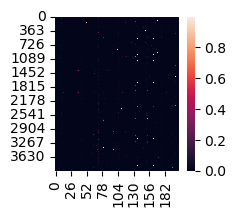

In [243]:
sns.heatmap(preds)